In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'ag01598'  # Your Kaggle username
os.environ['KAGGLE_KEY'] = 'f63fc2973c0715b843d0e7e996cccdc7'  # Your Kaggle API key
os.environ['URN'] = '6644818'  # Your URN: submissions without a URN will not count

#!kaggle competitions download -c uos-com2028-21-22-cw
#!unzip uos-com2028-21-22-cw.zip

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, utils
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical
from tensorflow.data import AUTOTUNE

import random
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass

2022-04-01 18:55:20.562123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 18:55:20.592540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 18:55:20.592718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Read the data

In [3]:
color_mode = 'grayscale'
image_size = (32, 32)
image_shape = (*image_size, 1)
batch_size = 1000

num_classes = 8

In [4]:
#read all labels
train_labels_dp = pd.read_csv('train.csv')
train_labels = tf.constant(train_labels_dp.loc[:, 'Cell type'].values)

2022-04-01 18:55:20.681981: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-01 18:55:20.682679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 18:55:20.682825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 18:55:20.683173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so 

In [5]:
#based on https://www.tensorflow.org/tutorials/load_data/images

def pathToLabel(path):
  path = tf.strings.regex_replace(path, "./train/", "")
  path = tf.strings.regex_replace(path, ".jpg", "")
  return train_labels[tf.strings.to_number(path, out_type=tf.int32)]

def decode_image(img):
  # channels were reduced to 1 since image is grayscale
  img = tf.io.decode_jpeg(img, channels=1)

  return tf.image.resize(img, image_size)

def process_path(path, addPath=False):
  label = pathToLabel(path)

  print (label)

  img = tf.io.read_file(path)
  img = decode_image(img)

  if addPath:
    return img, label, path
  else:
    return img, label

def configure_for_performance(ds: tf.data.Dataset) -> tf.data.Dataset:
  #ds = ds.cache()
  ds = ds.shuffle(buffer_size= 1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(AUTOTUNE)
  return ds

def prepare_dataset(ds: tf.data.Dataset) -> tf.data.Dataset:
  ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)
  ds = configure_for_performance(ds)
  return ds
  

In [6]:
seed = random.randint(0, 10000)

print("seed: %d" % seed)

# Read all the files from the direcotry
list_ds = tf.data.Dataset.list_files(str('./train/*'), shuffle=False)

image_count = len(list_ds)

list_ds = list_ds.shuffle(image_count, seed=seed)

val_size = int(image_count * 0.1)

train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

train_ds = prepare_dataset(train_ds)
val_ds   = prepare_dataset(val_ds)


seed: 8454
Tensor("strided_slice:0", shape=(), dtype=int64)
Tensor("strided_slice:0", shape=(), dtype=int64)


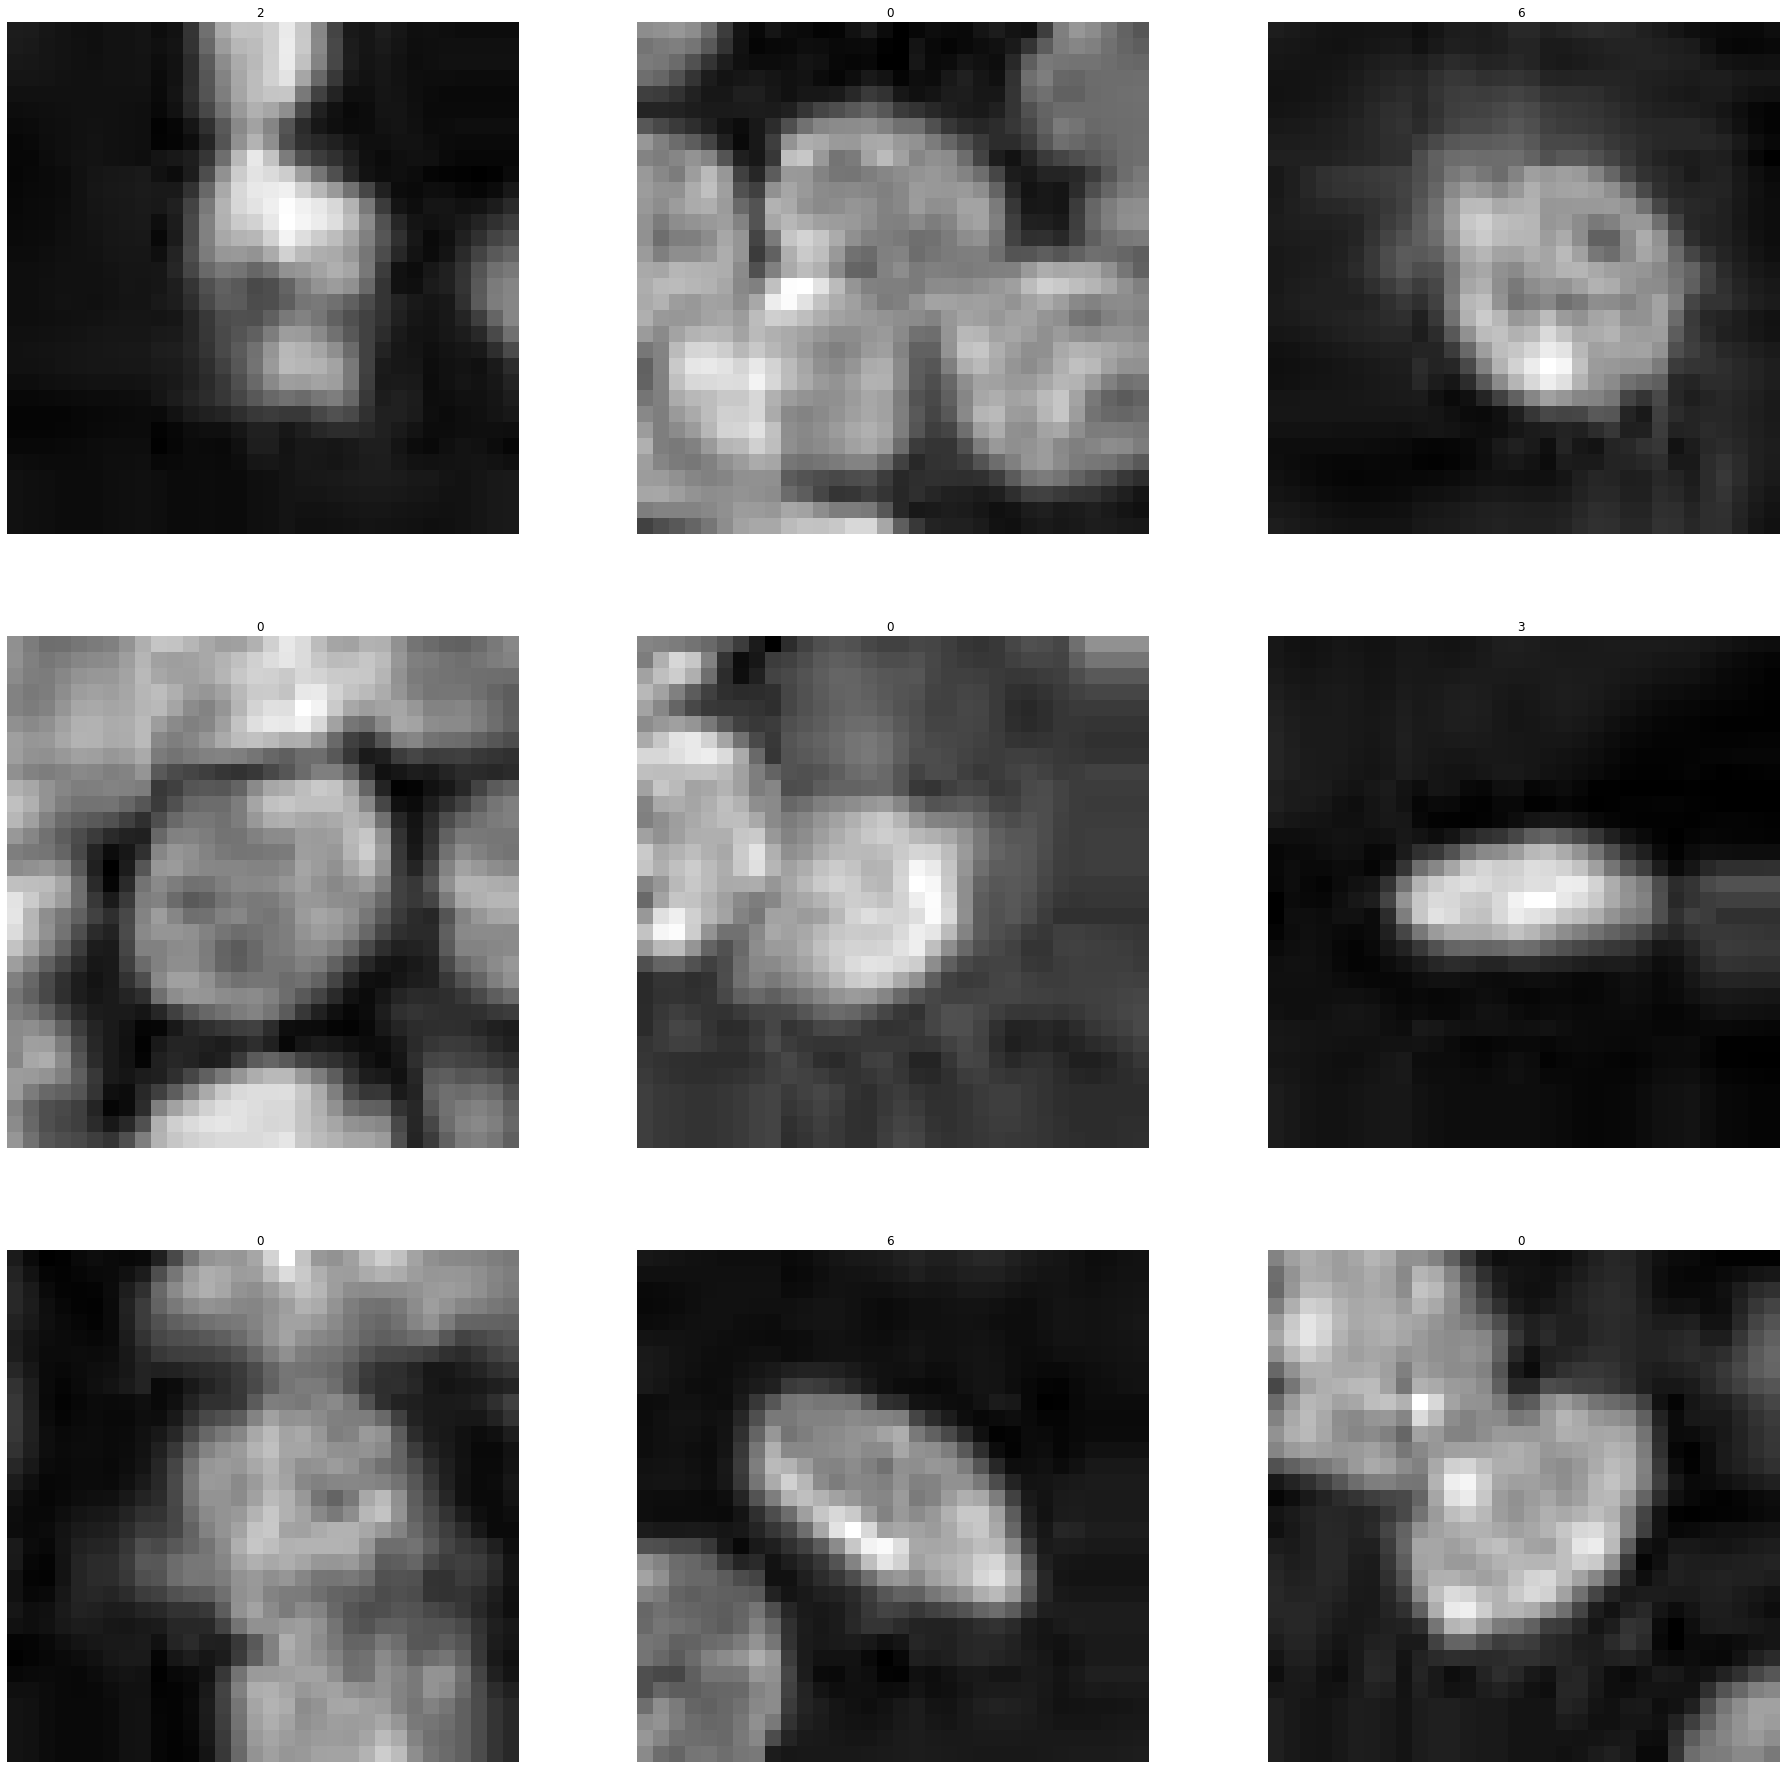

In [7]:
# Show some images
#image_batch, label_batch, path_batch = next(iter(train_ds))
image_batch, label_batch  = next(iter(train_ds))

plt.figure(figsize=image_size)
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray')

  label = label_batch[i]
  path = ""#str(path_batch[i].numpy())

  plt.title(str(label.numpy()) + " " + path)
  plt.axis("off")


Read the testing set

In [8]:
test_ds = image_dataset_from_directory(
  './test', 
  labels=None, 
  shuffle=False,
  color_mode=color_mode,
  batch_size=batch_size,
  image_size=image_size)

Found 50000 files belonging to 1 classes.


Create a model

In [9]:

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=image_shape),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.1),
  ]
)

model = keras.Sequential()

model.add(data_augmentation)

model.add(layers.Rescaling(1.0/255, input_shape=image_shape))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPool2D(padding='same'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))

for _ in range(5):
  model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))

model.add(layers.MaxPool2D(padding='same'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(
  loss=keras.losses.SparseCategoricalCrossentropy(),
  #loss=keras.losses.CategoricalCrossentropy(),
  #loss= keras.losses.Huber(),
  optimizer= keras.optimizers.Adam(),
  metrics=['accuracy']
)
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 1)         0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                      

In [10]:
def plot_loss(history, val=True, color="b", save=False):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['accuracy'], label='accuracy')
  if val:
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('error')
  plt.legend()
  plt.grid(True)
  if save:
    plt.savefig('./fig.png')
  else:
    plt.show()

Epoch 1/100
135/135 [==============================] - 15s 107ms/step - loss: 1.4947 - accuracy: 0.4621 - val_loss: 1.3408 - val_accuracy: 0.5051
Epoch 2/100
135/135 [==============================] - 15s 107ms/step - loss: 1.3391 - accuracy: 0.5055 - val_loss: 1.2808 - val_accuracy: 0.5311
Epoch 3/100
135/135 [==============================] - 16s 114ms/step - loss: 1.2726 - accuracy: 0.5283 - val_loss: 1.1775 - val_accuracy: 0.5659
Epoch 4/100
135/135 [==============================] - 16s 120ms/step - loss: 1.2259 - accuracy: 0.5447 - val_loss: 1.1716 - val_accuracy: 0.5684
Epoch 5/100
135/135 [==============================] - 17s 122ms/step - loss: 1.1816 - accuracy: 0.5620 - val_loss: 1.1221 - val_accuracy: 0.5897
Epoch 6/100
135/135 [==============================] - 17s 124ms/step - loss: 1.1630 - accuracy: 0.5704 - val_loss: 1.1466 - val_accuracy: 0.5717
Epoch 7/100
135/135 [==============================] - 18s 129ms/step - loss: 1.1420 - accuracy: 0.5773 - val_loss: 1.1246 -

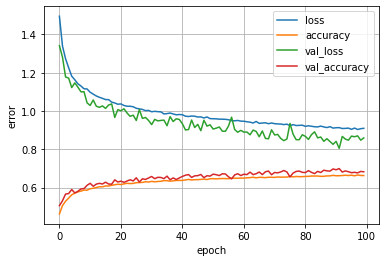

In [12]:
his = model.fit(train_ds, validation_data=val_ds, epochs=100)

plot_loss(his, save=True)

!notify-send -i "$(pwd)/fig.png" "AI: finished training"

In [13]:
predictions = [np.argmax(x) for x in model.predict(test_ds)]
predictions

[6,
 6,
 7,
 0,
 5,
 7,
 1,
 0,
 0,
 0,
 6,
 1,
 3,
 4,
 3,
 6,
 0,
 6,
 6,
 7,
 3,
 0,
 7,
 0,
 4,
 4,
 4,
 2,
 7,
 5,
 0,
 0,
 6,
 6,
 0,
 6,
 0,
 0,
 6,
 6,
 4,
 7,
 6,
 6,
 7,
 0,
 0,
 6,
 0,
 0,
 5,
 6,
 0,
 2,
 0,
 6,
 6,
 6,
 0,
 7,
 6,
 3,
 6,
 6,
 2,
 6,
 0,
 0,
 0,
 0,
 3,
 0,
 2,
 0,
 0,
 0,
 6,
 6,
 0,
 3,
 3,
 0,
 6,
 0,
 6,
 2,
 6,
 7,
 2,
 4,
 1,
 6,
 3,
 1,
 0,
 6,
 6,
 6,
 0,
 0,
 4,
 2,
 0,
 0,
 7,
 6,
 7,
 6,
 1,
 6,
 6,
 0,
 0,
 0,
 0,
 0,
 7,
 3,
 4,
 0,
 0,
 3,
 4,
 0,
 0,
 6,
 7,
 0,
 4,
 6,
 6,
 3,
 0,
 3,
 7,
 0,
 0,
 3,
 6,
 3,
 6,
 7,
 6,
 6,
 0,
 0,
 0,
 0,
 3,
 5,
 6,
 3,
 0,
 0,
 6,
 0,
 0,
 7,
 0,
 0,
 0,
 7,
 3,
 7,
 0,
 0,
 6,
 0,
 3,
 0,
 6,
 0,
 4,
 1,
 0,
 4,
 0,
 6,
 0,
 0,
 7,
 7,
 0,
 6,
 6,
 2,
 3,
 6,
 0,
 0,
 7,
 0,
 0,
 0,
 6,
 7,
 6,
 3,
 3,
 7,
 3,
 4,
 7,
 0,
 7,
 7,
 0,
 4,
 1,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 7,
 7,
 6,
 0,
 3,
 0,
 0,
 0,
 0,
 6,
 6,
 3,
 0,
 3,
 3,
 6,
 6,
 6,
 3,
 7,
 0,
 0,
 6,
 0,
 3,
 0,
 0,
 1,
 0,
 4,
 6,
 3,
 0,
 0,


In [14]:
from pandas import DataFrame
DataFrame(data={'Cell type': predictions}).to_csv('predictions.csv', index_label='Id')

In [15]:
!kaggle competitions submit -m $URN -c uos-com2028-21-22-cw -f predictions.csv

100%|█████████████████████████████████████████| 380k/380k [00:01<00:00, 226kB/s]
Successfully submitted to COM2028 21/22 CW